In [1]:
colors = {
    "p53": "#008DD5",
    "nutlin": "#DB5461",
    "nfkb": "#C33149",
    "tnf": "#107E7D",
    "gray": "#DAE0DC"
}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.signal import find_peaks
from tqdm import tqdm
import pickle
import gzip

In [4]:
kc1 = 300; # production of p53 [nM/h]
kc2 = 1 # degradation of p53 by mdm2 [1/h]
kc3 = 6; # degradation of p53 by mdm2 [nM]
kc4 = 0.03; # production of mdm2 - mRNA [1/(nM*h)]
kc5 = 0.5 # degradation of mdm2 - mRNA [1/h]
kc6 = 1.4 # production of mdm2 [1/h]
kc7 = 0.6 # degradation of mdm2 [1/h] 0.2
kc8 = 0.01 # binding of Mdm2 and nutlin [1/h]
kc9 = 1 # unbinding of Mdm2 and nutlin [1/h]

In [78]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 300, 200, 200, 1, 0.1 # Using 0.1 for nutlin seems to make it a lot more smooth than using 0?? Is this okay?

y0 = [p0, m0, Mf0, Mb0, n0]

In [79]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = kc4 * p**2 - kc5 * m
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf + kc9 * Mb # Last term new
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf - kc9 * Mb # Last term new
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf + kc9 * Mb # Last term new
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [80]:
# defining function to oscillate TNF (sinusoidal)
def TNF_sin_osc(oscillations, T_int, Amp, OOmega, N_n0, I_m0, I0, IKK_a0, IKK_i0):

    # calculating the period of TNF in order to simulate with the desired ratio of external over internal period
    T_ext = OOmega * T_int

    history = {"t":[] ,"N_n": [], "I_m": [], "I": [], "IKK_a":[], "IKK_i":[], "TNF":[]}

    
    for i in tqdm(range(oscillations)):
        if i == 0:
            state = N_n0, I_m0, I0, IKK_a0, IKK_i0
        else:
            state = history["N_n"][-1], history["I_m"][-1], history["I"][-1], history["IKK_a"][-1], history["IKK_i"][-1]

        sys = solve_ivp(system_nfkb, (0, T_ext), state, args=(Amp,), method='LSODA', max_step=0.5, dense_output=True) # Is this step size too low?
        
        N_n, I_m, I, IKK_a, IKK_i = sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]

        new_t = np.array(sys["t"]) + (history["t"][-1] if history["t"] else 0)
        history["t"].extend(new_t)
        history["N_n"].extend(N_n)
        history["I_m"].extend(I_m)
        history["I"].extend(I)
        history["IKK_a"].extend(IKK_a)
        history["IKK_i"].extend(IKK_i)
        history["TNF"].extend(k + Amp * np.sin(np.pi * (1 / T_ext) * new_t))

    return history, T_ext

In [81]:
# NFkB, Im, I, IKK_A, IKK_i
p0 = [0.037770776771579556, 0.4050017925580332, 4.076546559955566, 0.1799999999999995, 1.5500000000000012]

p0_delta = p0.copy()
p0_delta[0] = p0_delta[0] + 1e-15

In [82]:
# simulating system with sinus oscillations
sim_0, T_ext_0 = TNF_sin_osc(no_osc, T_intt, Amp1, omega, *p0)

100%|██████████| 200/200 [00:00<00:00, 206.49it/s]


In [83]:
# simulating system with sinus oscillations
sim_delta, T_ext_delta = TNF_sin_osc(no_osc, T_intt, Amp1, omega, *p0_delta)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 237.55it/s]


In [84]:
# unpacking
t0, N0, Im0, I0, IKK_a0, IKK_i0, TNF0 = np.array(sim_0["t"]), np.array(sim_0["N_n"]), np.array(sim_0["I_m"]), np.array(sim_0["I"]), np.array(sim_0["IKK_a"]), np.array(sim_0["IKK_i"]), np.array(sim_0["TNF"])

In [85]:
# unpacking
t1, N1, Im1, I1, IKK_a1, IKK_i1, TNF1 = np.array(sim_delta["t"]), np.array(sim_delta["N_n"]), np.array(sim_delta["I_m"]), np.array(sim_delta["I"]), np.array(sim_delta["IKK_a"]), np.array(sim_delta["IKK_i"]), np.array(sim_delta["TNF"])

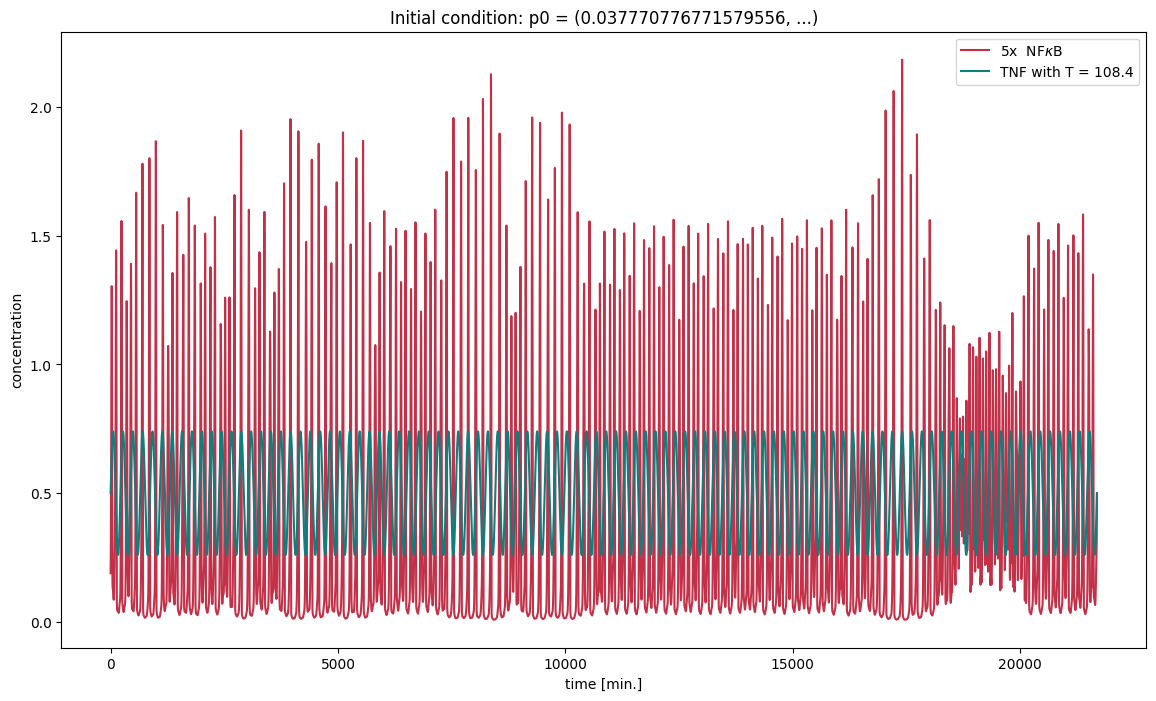

In [86]:
plt.figure(figsize=(14,8))
plt.plot(t0, x*N0, color=colors["nfkb"], alpha=1, label = f'{x}x  NF$\kappa$B')
plt.plot(t0, TNF0, alpha=1, color=colors["tnf"], label = f'TNF with T = {T_ext_0:.4}')
plt.title(rf'Initial condition: p0 = ({p0[0]}, ...)')
plt.xlabel('time [min.]')
plt.ylabel('concentration')
plt.legend()

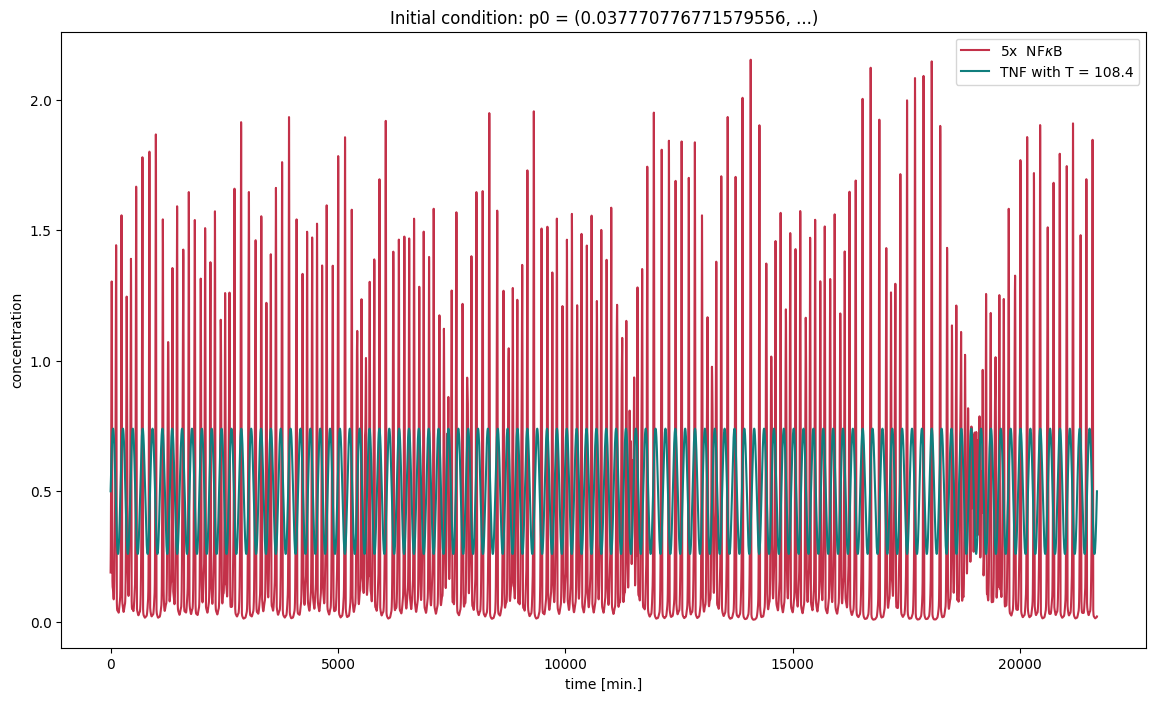

In [87]:
plt.figure(figsize=(14,8))
plt.plot(t1, x*N1, color=colors["nfkb"], alpha=1, label = f'{x}x  NF$\kappa$B')
plt.plot(t1, TNF1, alpha=1, color=colors["tnf"], label = f'TNF with T = {T_ext_0:.4}')
plt.title(rf'Initial condition: p0 = ({p0[0]}, ...)')
plt.xlabel('time [min.]')
plt.ylabel('concentration')
plt.legend()

# Divergens af trajectorier

Text(0.5, 0.92, 'Strange Attractor for NFkB')

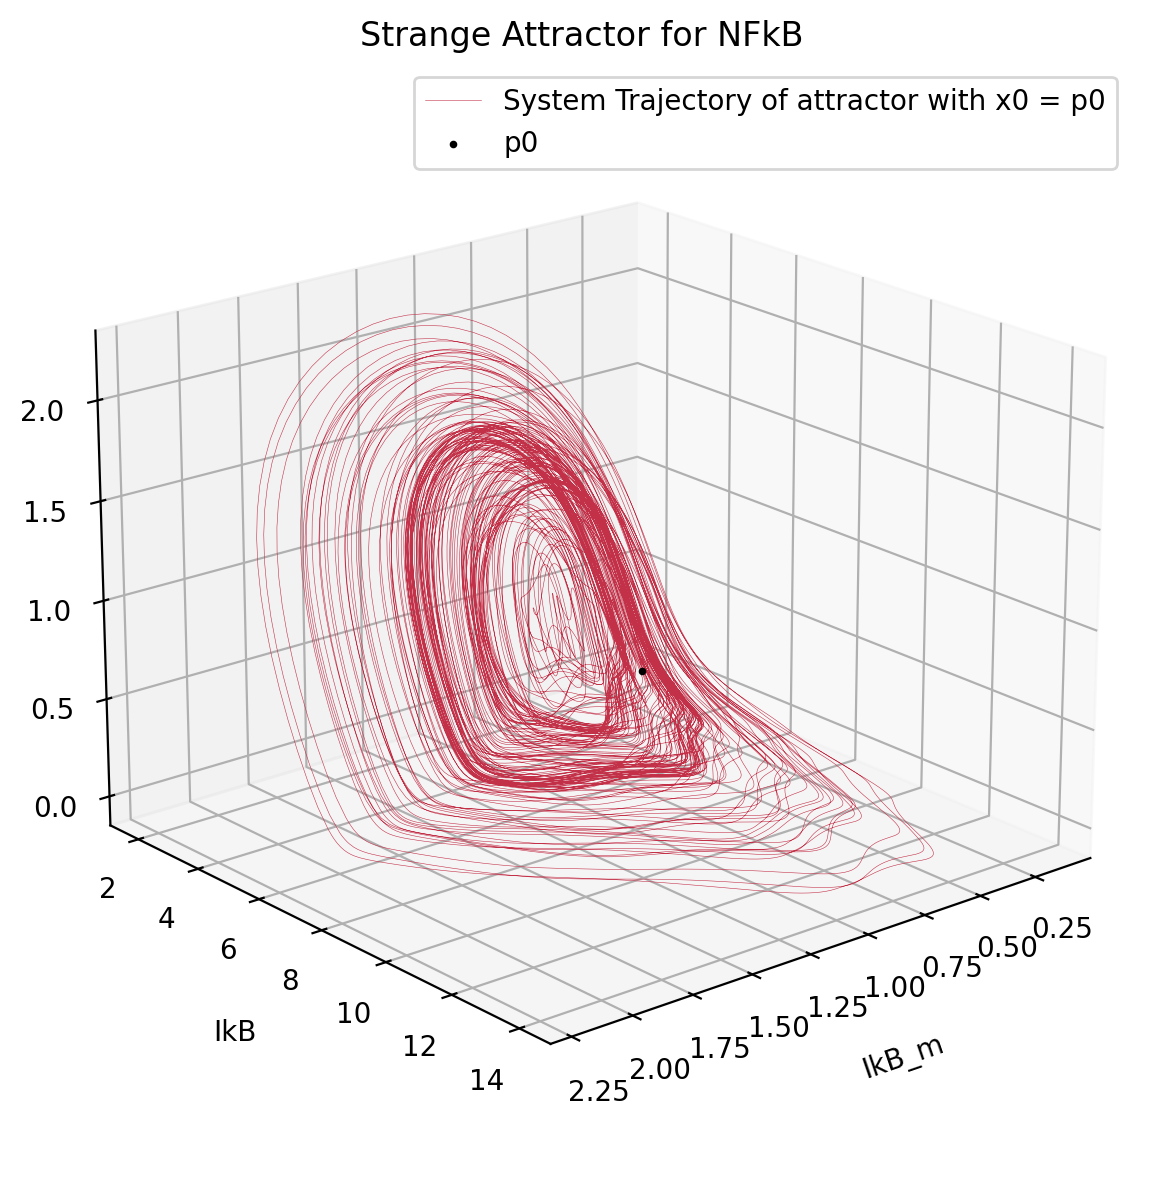

In [88]:
fig = plt.figure(figsize=(6, 6), dpi=200)
ax_3d = fig.add_subplot(111, projection='3d')  # Correct index for 3D plot
ax_3d.plot(Im0[transient_window:], I0[transient_window:], N0[transient_window:] * x, color=colors["nfkb"], lw=0.2, label=f'System Trajectory of attractor with x0 = p0')
ax_3d.scatter(Im0[0], I0[0], N0[0] * x, color="black", s=3, label=f'p0')
ax_3d.set_xlabel(r'IkB_m', labelpad=10)
ax_3d.set_ylabel('IkB', labelpad=10)
ax_3d.set_zlabel(f'{x}x NFkB', labelpad=10)
ax_3d.view_init(elev=20, azim=50) 

ax_3d.set_title(f'3D Phase Space')
ax_3d.legend()


plt.tight_layout()
plt.title("Strange Attractor for NFkB")

# Beregning af liapunov-eksponenten

In [90]:
trajectories = 30

In [91]:
all_final = []

for i in tqdm(range(trajectories)):
    # Generating a vector with length 1e-15 in a random direction
    v = np.random.rand(3)
    v_hat = (v / np.linalg.norm(v)) * 1e-15

    p0_d = p0.copy()
    p0_d[0:3] = p0_d[0:3]+ v_hat
    
    sim_j, T_ext_j = TNF_sin_osc(no_osc, T_intt, Amp1, omega, *p0_d)
    tj, Nj, Imj, Ij, IKK_aj, IKK_ij, TNFj = np.array(sim_j["t"]), np.array(sim_j["N_n"]), np.array(sim_j["I_m"]), np.array(sim_j["I"]), np.array(sim_j["IKK_a"]), np.array(sim_j["IKK_i"]), np.array(sim_j["TNF"])

    all_final.append([Imj[-1], Ij[-1], Nj[-1]])

100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


In [92]:
all_final = np.array(all_final)

Im_all = all_final[:, 0]
I_all = all_final[:, 1]
N_all = all_final[:, 2]

In [93]:
all_final

array([[9.59975586e-01, 1.14823263e+01, 2.49375029e-03],
       [2.52536563e-01, 8.23522811e+00, 5.18381662e-03],
       [4.72144550e-01, 1.13442693e+01, 2.55035964e-03],
       [2.57106346e-01, 6.08607216e+00, 1.08126870e-02],
       [5.57178778e-01, 3.65174640e+00, 5.81083775e-02],
       [3.60923728e-01, 6.62573085e+00, 8.74777688e-03],
       [6.23054033e-01, 6.14170790e+00, 1.07440214e-02],
       [3.99381802e-01, 3.40868091e+00, 6.86035870e-02],
       [9.85833116e-01, 7.26782130e+00, 7.09050746e-03],
       [3.38895398e-01, 4.33299592e+00, 2.89512556e-02],
       [1.17524640e+00, 4.21187302e+00, 1.03309228e-01],
       [4.25558301e-01, 5.09148064e+00, 1.78420841e-02],
       [2.56036338e-01, 2.79441952e+00, 1.22899086e-01],
       [5.11594832e-01, 1.27732203e+01, 1.97917306e-03],
       [4.12003452e-01, 3.31508389e+00, 7.69390933e-02],
       [6.68003713e-01, 6.99862182e+00, 7.71113171e-03],
       [6.92320903e-01, 4.36467370e+00, 3.05863848e-02],
       [6.95959044e-01, 6.27433

Text(0.5, 0.92, 'Strange Attractor for NFkB')

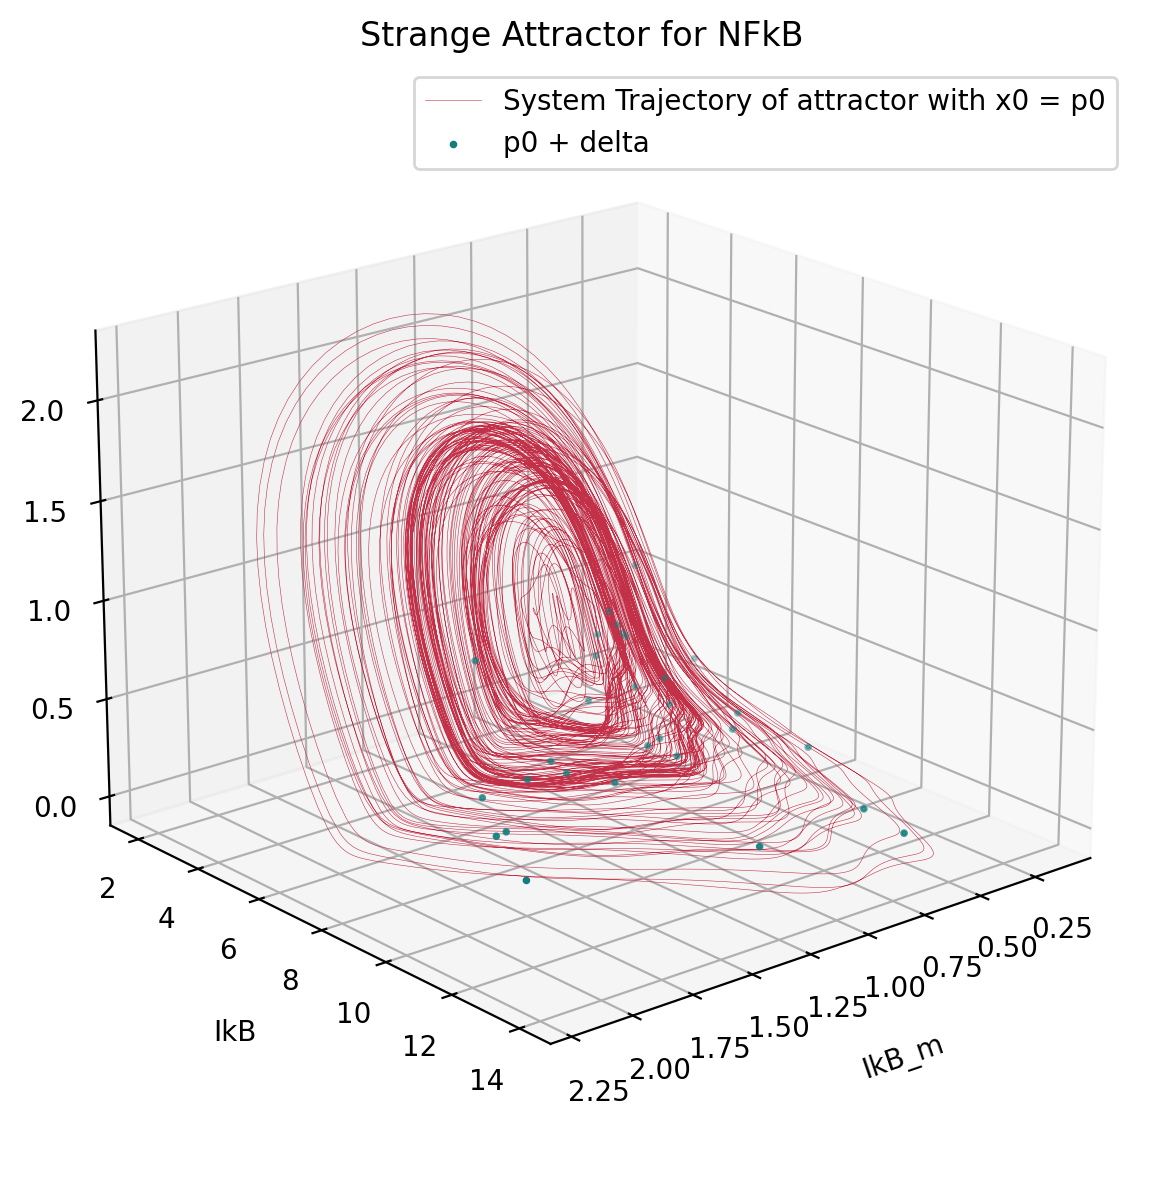

In [96]:
fig = plt.figure(figsize=(6, 6), dpi=200)
ax_3d = fig.add_subplot(111, projection='3d')  # Correct index for 3D plot
ax_3d.plot(Im0[transient_window:], I0[transient_window:], N0[transient_window:] * x, color=colors["nfkb"], lw=0.2, label=f'System Trajectory of attractor with x0 = p0')
ax_3d.scatter(Im_all, I_all, N_all * x, color=colors["tnf"], s=3, label=f'p0 + delta')
ax_3d.set_xlabel(r'IkB_m', labelpad=10)
ax_3d.set_ylabel('IkB', labelpad=10)
ax_3d.set_zlabel(f'{x}x NFkB', labelpad=10)
ax_3d.view_init(elev=20, azim=50) 

ax_3d.set_title(f'3D Phase Space')
ax_3d.legend()


plt.tight_layout()
plt.title("Strange Attractor for NFkB")